This notebook contains the training process of the model that is **actively used** in the final application.  
Model training, evaluation, and saving steps are performed here, and the `.pth` model file integrated into the application was generated from this code.  
This file represents the **main model** of the project.

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models, transforms
from PIL import Image
import nltk
from nltk.corpus import stopwords
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from sklearn.model_selection import train_test_split
import re
import json

nltk.download('stopwords')

# ----- CONFIG -----
MAX_SEQ_LEN = 100
BATCH_SIZE = 16
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- TEXT PROCESSING UTILS -----
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9 ]', '', text)
    return ' '.join([word for word in text.split() if word not in stop_words])

# ----- LOAD DATA -----
df_train = pd.read_csv(r"C:\Users\akadi\Desktop\Bitirme\Code\Data\Split Dataset\Training_meme_dataset.csv")
df_val = pd.read_csv(r"C:\Users\akadi\Desktop\Bitirme\Code\Data\Split Dataset\Validation_meme_dataset.csv")
df_test = pd.read_csv(r"C:\Users\akadi\Desktop\Bitirme\Code\Data\Split Dataset\Testing_meme_dataset.csv")

for df in [df_train, df_val, df_test]:
    df['sentence'] = df['sentence'].astype(str).apply(clean_text)
    df['label'] = df['label'].astype('category').cat.codes


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akadi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# ----- TEXT VOCAB BUILDING -----
all_text = ' '.join(df_train['sentence']).split()
vocab = {word: idx + 1 for idx, (word, _) in enumerate(Counter(all_text).most_common())}
vocab['<PAD>'] = 0

# ----- TEXT DATASET -----
class TextDataset(Dataset):
    def __init__(self, df):
        self.texts = df['sentence'].tolist()
        self.labels = df['label'].tolist()

    def __len__(self):
        return len(self.labels)

    def encode(self, text):
        tokens = [vocab.get(word, 0) for word in text.split()]
        return torch.tensor(tokens[:MAX_SEQ_LEN])

    def __getitem__(self, idx):
        text = self.encode(self.texts[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return text, label

# Collate function for padding
collate_fn = lambda batch: (
    pad_sequence([item[0] for item in batch], batch_first=True),
    torch.tensor([item[1] for item in batch], dtype=torch.float)
)

train_loader = DataLoader(TextDataset(df_train), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(TextDataset(df_val), batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(TextDataset(df_test), batch_size=BATCH_SIZE, collate_fn=collate_fn)


In [3]:
# ----- TEXT MODEL -----
class TextLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=128):
        super(TextLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (h, _) = self.lstm(x)
        h = torch.cat((h[-2], h[-1]), dim=1)
        return self.sigmoid(self.fc(h)).squeeze()
    # ----- TEXT MODEL LOAD -----
text_model_path = "Stack_LSTM_txt_model.pth"
text_model = TextLSTM(len(vocab)).to(DEVICE)

train_loader_text = DataLoader(TextDataset(df_train), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader_text = DataLoader(TextDataset(df_test), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)



In [4]:

if os.path.exists(text_model_path):
    text_model.load_state_dict(torch.load(text_model_path))
    text_model.eval()
    print("[Text Model] Loaded from disk.")
else:
     print("[Text Model] not on the disk.")

[Text Model] Loaded from disk.


In [93]:

print("[Text Model] Training from scratch...")
criterion = nn.BCELoss()
optimizer = optim.Adam(text_model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    text_model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = text_model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")


[Text Model] Training from scratch...
Epoch 1/10, Loss: 0.6884
Epoch 2/10, Loss: 0.6047
Epoch 3/10, Loss: 0.8650
Epoch 4/10, Loss: 0.2026
Epoch 5/10, Loss: 0.0893
Epoch 6/10, Loss: 0.0174
Epoch 7/10, Loss: 0.0977
Epoch 8/10, Loss: 0.0238
Epoch 9/10, Loss: 0.0037
Epoch 10/10, Loss: 0.0022


In [95]:
torch.save(text_model.state_dict(), text_model_path)
print("[Text Model] Saved to disk.")

[Text Model] Saved to disk.


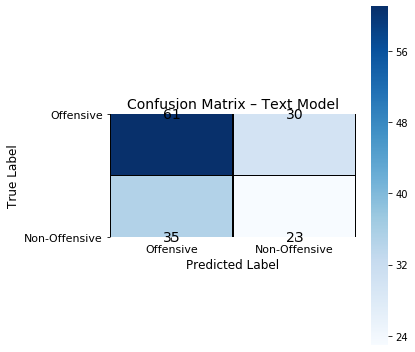

               precision    recall  f1-score   support

Non-Offensive       0.64      0.67      0.65        91
    Offensive       0.43      0.40      0.41        58

     accuracy                           0.56       149
    macro avg       0.53      0.53      0.53       149
 weighted avg       0.56      0.56      0.56       149



In [7]:
# ----- CONFUSION MATRIX -----
y_true = []
y_pred = []

text_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = text_model(inputs)
        preds = (outputs > 0.5).long().cpu().numpy()
        y_true.extend(labels.numpy().astype(int))
        y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    square=True,
    linewidths=0.5,
    linecolor='black',
    annot_kws={"color": "black", "size": 14}
)

ax.set_title("Confusion Matrix – Text Model", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)
ax.set_xticklabels(['Offensive', 'Non-Offensive'], fontsize=11)
ax.set_yticklabels(['Offensive', 'Non-Offensive'], fontsize=11, rotation=0)

plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=['Non-Offensive', 'Offensive']))


In [5]:
# ----- CONFIG -----  image
BATCH_SIZE = 16
EPOCHS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- IMAGE DATASET -----
class ImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform):
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.df.iloc[idx]['image_name'])
        image = Image.open(img_name).convert('RGB')
        label = torch.tensor(self.df.iloc[idx]['label'], dtype=torch.float)
        if self.transform:
            image = self.transform(image)
        return image, label

# ----- TRANSFORMS -----
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [6]:
# ----- LOAD DATA -----
df_train = pd.read_csv(r"C:\Users\akadi\Desktop\Bitirme\Code\Data\Split Dataset\Training_meme_dataset.csv")
df_val = pd.read_csv(r"C:\Users\akadi\Desktop\Bitirme\Code\Data\Split Dataset\Validation_meme_dataset.csv")
df_test = pd.read_csv(r"C:\Users\akadi\Desktop\Bitirme\Code\Data\Split Dataset\Testing_meme_dataset.csv")

for df in [df_train, df_val, df_test]:
    df['label'] = df['label'].astype('category').cat.codes

img_dir = r"C:\Users\akadi\Desktop\Bitirme\Code\Data\Labelled Images"

train_loader = DataLoader(ImageDataset(df_train, img_dir, transform), batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(ImageDataset(df_val, img_dir, transform), batch_size=BATCH_SIZE)
test_loader = DataLoader(ImageDataset(df_test, img_dir, transform), batch_size=BATCH_SIZE, shuffle=False)

# ----- IMAGE MODEL -----
class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        self.base = models.vgg16(pretrained=True)
        for param in self.base.parameters():
            param.requires_grad = False
        self.classifier = nn.Sequential(
            nn.Linear(25088, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.base.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x).squeeze()

image_model_path = "VGG16_img_model.pth"
image_model = ImageClassifier().to(DEVICE)

train_loader_image = DataLoader(ImageDataset(df_train, img_dir, transform), batch_size=BATCH_SIZE, shuffle=False)
test_loader_image = DataLoader(ImageDataset(df_test, img_dir, transform), batch_size=BATCH_SIZE, shuffle=False)


In [7]:

if os.path.exists(image_model_path):
    image_model.load_state_dict(torch.load(image_model_path))
    image_model.eval()
    print("[Image Model] Loaded from disk.")
else:
     print("[Image Model] not on the disk.")

[Image Model] Loaded from disk.


In [98]:
# ----- IMAGE MODEL LOAD / TRAIN / SAVE -----
image_model_path = "VGG16_img_model.pth"
image_model = ImageClassifier().to(DEVICE)

print("[Image Model] Training from scratch...")
criterion = nn.BCELoss()
optimizer = optim.Adam(image_model.classifier.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    image_model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = image_model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")

torch.save(image_model.state_dict(), image_model_path)
print("[Image Model] Saved to disk.")

[Image Model] Training from scratch...
Epoch 1/10, Loss: 0.6942
Epoch 2/10, Loss: 0.5253
Epoch 3/10, Loss: 0.3378
Epoch 4/10, Loss: 0.3029
Epoch 5/10, Loss: 0.0761
Epoch 6/10, Loss: 0.0281
Epoch 7/10, Loss: 0.0930
Epoch 8/10, Loss: 0.0375
Epoch 9/10, Loss: 0.0263
Epoch 10/10, Loss: 0.0805
[Image Model] Saved to disk.


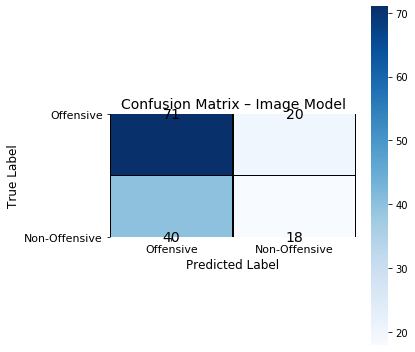

               precision    recall  f1-score   support

Non-Offensive       0.64      0.78      0.70        91
    Offensive       0.47      0.31      0.38        58

     accuracy                           0.60       149
    macro avg       0.56      0.55      0.54       149
 weighted avg       0.58      0.60      0.58       149



In [99]:
# ----- IMAGE CONFUSION MATRIX -----
y_true = []
y_pred = []

image_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = image_model(inputs)
        preds = (outputs > 0.5).long().cpu().numpy()
        y_true.extend(labels.numpy().astype(int))
        y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    square=True,
    linewidths=0.5,
    linecolor='black',
    annot_kws={"color": "black", "size": 14}
)

ax.set_title("Confusion Matrix – Image Model", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)
ax.set_xticklabels(['Offensive', 'Non-Offensive'], fontsize=11)
ax.set_yticklabels(['Offensive', 'Non-Offensive'], fontsize=11, rotation=0)

plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=['Non-Offensive', 'Offensive']))


In [8]:
# Full PyTorch Reimplementation of Text (Stacked LSTM), Image (VGG16), and Multimodal Model

# ... [image and text model code remains above as is] ...

# ----- MULTIMODAL MODEL DEFINITION -----
class MultimodalModel(nn.Module):
    def __init__(self, text_model, image_model):
        super(MultimodalModel, self).__init__()
        self.text_branch = text_model
        self.image_branch = image_model
        self.fc = nn.Sequential(
            nn.Linear(256 + 25088, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, text_input, image_input):
        text_feat = self.text_branch(text_input)
        image_feat = self.image_branch(image_input)
        combined = torch.cat((text_feat, image_feat), dim=1)
        return self.fc(combined).squeeze()

# ----- TEXT FEATURE EXTRACTOR WRAPPER -----
class TextFeatureExtractor(nn.Module):
    def __init__(self, base):
        super(TextFeatureExtractor, self).__init__()
        self.embedding = base.embedding
        self.lstm = base.lstm

    def forward(self, x):
        x = self.embedding(x)
        _, (h, _) = self.lstm(x)
        return torch.cat((h[-2], h[-1]), dim=1)

# ----- IMAGE FEATURE EXTRACTOR WRAPPER -----
class ImageFeatureExtractor(nn.Module):
    def __init__(self, base):
        super(ImageFeatureExtractor, self).__init__()
        self.features = base.base.features

    def forward(self, x):
        x = self.features(x)
        return torch.flatten(x, 1)

In [9]:
# ----- WRAPPED MODELS -----
text_feat_model = TextFeatureExtractor(text_model).to(DEVICE)
image_feat_model = ImageFeatureExtractor(image_model).to(DEVICE)

# ----- DATA LOADERS FOR MULTIMODAL -----
train_loader_text = DataLoader(TextDataset(df_train), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader_text = DataLoader(TextDataset(df_test), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


# ----- MULTIMODAL MODEL LOAD / TRAIN / SAVE -----
multimodal_model_path = "Stack_LSTM_VGG_mul_model.pth"
multimodal_model = MultimodalModel(text_feat_model, image_feat_model).to(DEVICE)

In [10]:

if os.path.exists(multimodal_model_path):
    multimodal_model.load_state_dict(torch.load(multimodal_model_path))
    multimodal_model.eval()
    print("[Multimodal Model] Loaded from disk.")
else:
     print("[Multimodal Model] not on the disk.")

[Multimodal Model] Loaded from disk.


In [20]:
print("[Multimodal Model] Training from scratch...")
criterion = nn.BCELoss()
optimizer = optim.Adam(multimodal_model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    multimodal_model.train()
    for ((text_inputs, text_labels), (img_inputs, img_labels)) in zip(train_loader_text, train_loader_image):
        text_inputs, text_labels = text_inputs.to(DEVICE), text_labels.to(DEVICE)
        img_inputs, img_labels = img_inputs.to(DEVICE), img_labels.to(DEVICE)

        labels = ((text_labels + img_labels) / 2).round()
        outputs = multimodal_model(text_inputs, img_inputs)

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")

torch.save(multimodal_model.state_dict(), multimodal_model_path)
print("[Multimodal Model] Saved to disk.")


[Multimodal Model] Training from scratch...
Epoch 1/5, Loss: 0.0001
Epoch 2/5, Loss: 0.0033
Epoch 3/5, Loss: 0.0023
Epoch 4/5, Loss: 0.1729
Epoch 5/5, Loss: 0.0058
[Multimodal Model] Saved to disk.


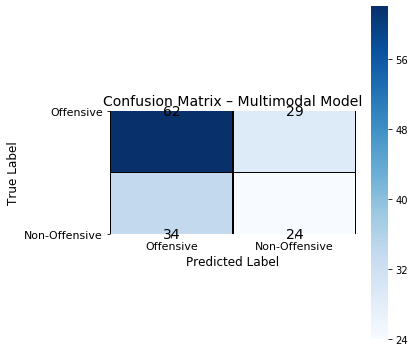

               precision    recall  f1-score   support

Non-Offensive       0.65      0.68      0.66        91
    Offensive       0.45      0.41      0.43        58

     accuracy                           0.58       149
    macro avg       0.55      0.55      0.55       149
 weighted avg       0.57      0.58      0.57       149



In [21]:
# ----- MULTIMODAL CONFUSION MATRIX -----
y_true = []
y_pred = []

multimodal_model.eval()
with torch.no_grad():
    for ((text_inputs, text_labels), (img_inputs, img_labels)) in zip(test_loader_text, test_loader):
        text_inputs = text_inputs.to(DEVICE)
        img_inputs = img_inputs.to(DEVICE)
        outputs = multimodal_model(text_inputs, img_inputs)
        preds = (outputs > 0.5).long().cpu().numpy()
        y_true.extend(text_labels.numpy().astype(int))
        y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    square=True,
    linewidths=0.5,
    linecolor='black',
    annot_kws={"color": "black", "size": 14}
)

ax.set_title("Confusion Matrix – Multimodal Model", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)
ax.set_xticklabels(['Offensive', 'Non-Offensive'], fontsize=11)
ax.set_yticklabels(['Offensive', 'Non-Offensive'], fontsize=11, rotation=0)

plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=['Non-Offensive', 'Offensive']))


In [14]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Model ve eğitim parametreleri
criterion = nn.BCELoss()
optimizer = optim.Adam(text_model.parameters(), lr=1e-3)

train_accuracies = []
train_losses = []

for epoch in range(EPOCHS):
    text_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader_text:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = text_model(inputs)
        
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader_text)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


Epoch [1/5] - Loss: 3.0423, Accuracy: 0.4202
Epoch [2/5] - Loss: 0.6905, Accuracy: 0.5843
Epoch [3/5] - Loss: 0.6912, Accuracy: 0.5663
Epoch [4/5] - Loss: 0.6221, Accuracy: 0.5708
Epoch [5/5] - Loss: 0.5512, Accuracy: 0.6921


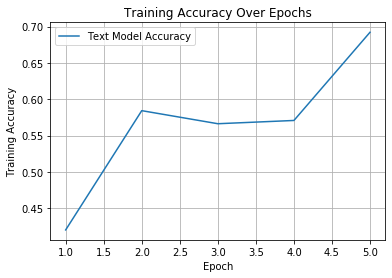

In [15]:
plt.plot(range(1, EPOCHS+1), train_accuracies, label="Text Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
print(df_train.columns)


Index(['image_name', 'sentence', 'label'], dtype='object')


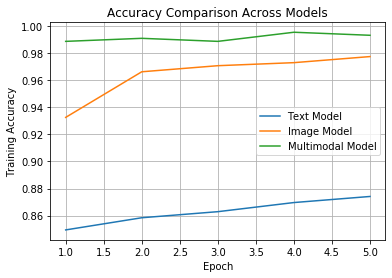

In [20]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# 📁 Görsel klasör yolu
image_dir = r"C:\Users\akadi\Desktop\Bitirme\Code\Data\Labelled Images"

# 🔧 Görsel transform
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ✅ Eksik DataLoader'lar
train_dataset_img = ImageDataset(df_train, image_dir=image_dir, transform=img_transform)
train_loader_img = DataLoader(train_dataset_img, batch_size=BATCH_SIZE, shuffle=True)

# 🔄 MultimodalDataset içinde 'image_name' kullanalım
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.texts = dataframe['sentence'].tolist()
        self.image_paths = dataframe['image_name'].tolist()  # ← düzeltildi
        self.labels = dataframe['label'].tolist()
        self.image_dir = image_dir
        self.transform = transform

    def encode_text(self, text):
        tokens = [vocab.get(word, 0) for word in text.split()]
        return torch.tensor(tokens[:MAX_SEQ_LEN])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text_tensor = self.encode_text(self.texts[idx])
        image_path = os.path.join(self.image_dir, self.image_paths[idx])
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return (text_tensor, image, label)

# 🔗 collate fonksiyonu
def multimodal_collate_fn(batch):
    text_batch = [item[0] for item in batch]
    image_batch = [item[1] for item in batch]
    label_batch = [item[2] for item in batch]
    text_batch = torch.nn.utils.rnn.pad_sequence(text_batch, batch_first=True)
    image_batch = torch.stack(image_batch)
    label_batch = torch.tensor(label_batch, dtype=torch.float)
    return (text_batch, image_batch, label_batch)

train_dataset_multimodal = MultimodalDataset(df_train, image_dir=image_dir, transform=img_transform)
train_loader_multimodal = DataLoader(train_dataset_multimodal, batch_size=BATCH_SIZE, shuffle=True, collate_fn=multimodal_collate_fn)

# 🔁 Eğitim başlasın
criterion = nn.BCELoss()
train_accuracies_text, train_losses_text = [], []
train_accuracies_image, train_losses_image = [], []
train_accuracies_multi, train_losses_multi = [], []

# 📘 TEXT MODEL
optimizer_text = optim.Adam(text_model.parameters(), lr=1e-3)
for epoch in range(EPOCHS):
    text_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader_text:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = text_model(inputs)
        loss = criterion(outputs, labels)
        optimizer_text.zero_grad()
        loss.backward()
        optimizer_text.step()
        running_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_losses_text.append(running_loss / len(train_loader_text))
    train_accuracies_text.append(correct / total)

# 🖼️ IMAGE MODEL
optimizer_image = optim.Adam(image_model.parameters(), lr=1e-3)
for epoch in range(EPOCHS):
    image_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader_img:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = image_model(inputs)
        loss = criterion(outputs, labels)
        optimizer_image.zero_grad()
        loss.backward()
        optimizer_image.step()
        running_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_losses_image.append(running_loss / len(train_loader_img))
    train_accuracies_image.append(correct / total)

# 🔀 MULTIMODAL MODEL
optimizer_multi = optim.Adam(multimodal_model.parameters(), lr=1e-3)
for epoch in range(EPOCHS):
    multimodal_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for text_inputs, img_inputs, labels in train_loader_multimodal:
        text_inputs = text_inputs.to(DEVICE)
        img_inputs = img_inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = multimodal_model(text_inputs, img_inputs)
        loss = criterion(outputs, labels)
        optimizer_multi.zero_grad()
        loss.backward()
        optimizer_multi.step()
        running_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_losses_multi.append(running_loss / len(train_loader_multimodal))
    train_accuracies_multi.append(correct / total)

# 📊 Accuracy grafiği
plt.plot(range(1, EPOCHS+1), train_accuracies_text, label="Text Model")
plt.plot(range(1, EPOCHS+1), train_accuracies_image, label="Image Model")
plt.plot(range(1, EPOCHS+1), train_accuracies_multi, label="Multimodal Model")

plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("Accuracy Comparison Across Models")
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# TEST için Image ve Multimodal verisi hazırlanıyor
test_dataset_img = ImageDataset(df_test, image_dir=image_dir, transform=img_transform)
test_loader_img = DataLoader(test_dataset_img, batch_size=BATCH_SIZE, shuffle=False)

test_dataset_multimodal = MultimodalDataset(df_test, image_dir=image_dir, transform=img_transform)
test_loader_multimodal = DataLoader(test_dataset_multimodal, batch_size=BATCH_SIZE, shuffle=False, collate_fn=multimodal_collate_fn)


In [24]:
train_accuracies_image, test_accuracies_image = [], []
train_accuracies_multi, test_accuracies_multi = [], []

# 🖼️ IMAGE MODEL
optimizer_image = optim.Adam(image_model.parameters(), lr=1e-3)
for epoch in range(EPOCHS):
    image_model.train()
    correct_train, total_train = 0, 0
    for inputs, labels in train_loader_img:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = image_model(inputs)
        loss = criterion(outputs, labels)
        optimizer_image.zero_grad()
        loss.backward()
        optimizer_image.step()
        preds = (outputs > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
    train_accuracies_image.append(correct_train / total_train)

    # ✅ Test doğruluğu
    image_model.eval()
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader_img:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = image_model(inputs)
            preds = (outputs > 0.5).float()
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)
    test_accuracies_image.append(correct_test / total_test)

# 🔀 MULTIMODAL MODEL
optimizer_multi = optim.Adam(multimodal_model.parameters(), lr=1e-3)
for epoch in range(EPOCHS):
    multimodal_model.train()
    correct_train, total_train = 0, 0
    for text_inputs, img_inputs, labels in train_loader_multimodal:
        text_inputs = text_inputs.to(DEVICE)
        img_inputs = img_inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = multimodal_model(text_inputs, img_inputs)
        loss = criterion(outputs, labels)
        optimizer_multi.zero_grad()
        loss.backward()
        optimizer_multi.step()
        preds = (outputs > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
    train_accuracies_multi.append(correct_train / total_train)

    # ✅ Test doğruluğu
    multimodal_model.eval()
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for text_inputs, img_inputs, labels in test_loader_multimodal:
            text_inputs = text_inputs.to(DEVICE)
            img_inputs = img_inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = multimodal_model(text_inputs, img_inputs)
            preds = (outputs > 0.5).float()
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)
    test_accuracies_multi.append(correct_test / total_test)


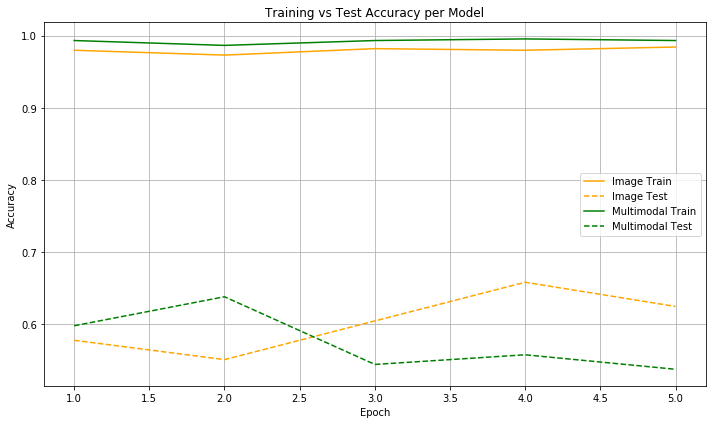

In [25]:
plt.figure(figsize=(10, 6))

# Image model
plt.plot(range(1, EPOCHS+1), train_accuracies_image, 'orange', label="Image Train")
plt.plot(range(1, EPOCHS+1), test_accuracies_image, 'orange', linestyle='--', label="Image Test")

# Multimodal model
plt.plot(range(1, EPOCHS+1), train_accuracies_multi, 'green', label="Multimodal Train")
plt.plot(range(1, EPOCHS+1), test_accuracies_multi, 'green', linestyle='--', label="Multimodal Test")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Test Accuracy per Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


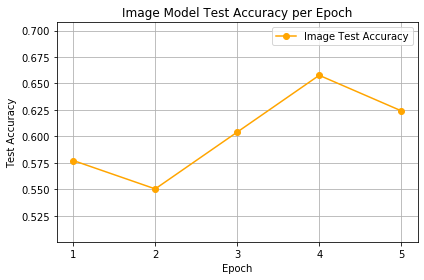

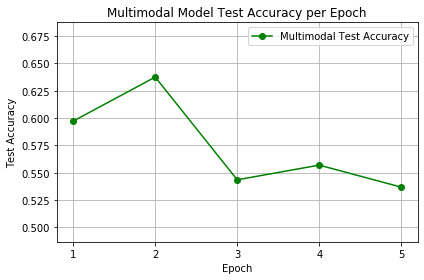

In [27]:
import matplotlib.pyplot as plt

# 📊 SADECE IMAGE MODEL TEST ACCURACY
plt.figure(figsize=(6, 4))
plt.plot(range(1, EPOCHS+1), test_accuracies_image, 'o-', color='orange', label="Image Test Accuracy")
plt.xticks(range(1, EPOCHS+1))
plt.ylim(min(test_accuracies_image)-0.05, max(test_accuracies_image)+0.05)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Image Model Test Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 SADECE MULTIMODAL MODEL TEST ACCURACY
plt.figure(figsize=(6, 4))
plt.plot(range(1, EPOCHS+1), test_accuracies_multi, 'o-', color='green', label="Multimodal Test Accuracy")
plt.xticks(range(1, EPOCHS+1))
plt.ylim(min(test_accuracies_multi)-0.05, max(test_accuracies_multi)+0.05)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Multimodal Model Test Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
